In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE

### Seed fixation

In [3]:
seed_value = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

### Process data

In [5]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")
df.sort_index(inplace=True)
df.head(3)

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-09 10:14:33,0.026588,0.040111,1.33020,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
2020-03-09 10:14:34,0.026170,0.040453,1.35399,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2020-03-09 10:14:35,0.026199,0.039419,1.54006,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0


### Make predictor

In [12]:
from keras.models import Sequential
from keras import backend as K
from keras.models import Model
from keras.layers import TimeDistributed, Dense, LSTM, RepeatVector, Input, Lambda, Layer


class KLLossLayer(Layer):
    def vae_loss(self, x, decoder_out, z_mean, z_sigma):
        x = K.flatten(x)
        decoder_out = K.flatten(decoder_out)        
        # KL divergence
        return tf.keras.losses.MeanSquaredError()(x,decoder_out) + K.mean(K.square(z_mean)+ 2*K.square(z_sigma))

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        decoder_out = inputs[1]
        z_mean = inputs[2]
        z_sigma = inputs[3]
        
        loss = self.vae_loss(x, decoder_out, z_mean, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x
    
class LSTM_VAE:
    def __init__(self, activation="relu"):
        self.activation = activation
        
    def fit(self, x_train, epochs, batch_size):        
        windos_count, TIME_STEPS, n_features = x_train.shape
        z_dim = n_features - 1
        encoder_input = Input( shape = (TIME_STEPS, n_features))
        
        encoder_LSTM = LSTM(units = 128, activation=self.activation, return_sequences = False)
        h = encoder_LSTM(encoder_input)
        z_mean = Dense(z_dim)(h)
        z_sigma = Dense(z_dim)(h)        
        def sampling(args):
            z_mean, z_sigma = args
            epsilon = K.random_normal(shape=(z_dim, ), mean = 0, stddev=1)
            return z_mean + epsilon * z_sigma
        
        decoder_input = Lambda(sampling)([z_mean, z_sigma]) # z        
        
        decoder_LSTM = LSTM(units = 128, activation=self.activation, return_sequences = True)
        decoder_out = decoder_LSTM(RepeatVector(TIME_STEPS)(decoder_input))
        decoder_dense = TimeDistributed(Dense(n_features, activation = self.activation))
        decoder_out = decoder_dense(decoder_out)
        
        y = KLLossLayer()([encoder_input, decoder_out, z_mean, z_sigma])
        vae = Model(encoder_input, y)
        
        vae.compile(optimizer = 'rmsprop')
        
        
        vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)
        self.vae = vae
        return self
    
    def predict(self, x_test):
        return self.vae.predict(x_test)

In [13]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [20]:
from utils.pipeline import Pipeline, Predictor

class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 10
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_VAE_Predictor(Predictor):
    def make_prediction(self, df):
        first_anomaly_idx = df.index.get_loc(df[df["anomaly"] == 1].index[0])
        df = df.drop(['anomaly','changepoint'], axis=1)
        conf.train_size = first_anomaly_idx
        ss = StandardScaler()
        
        x_train = np.array(ss.fit_transform(df[:conf.train_size]))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        model = LSTM_VAE()
        model.fit(x_train, conf.epochs, conf.batch_size)

        x_test = np.array(ss.transform(df))
        x_test = create_sequences(x_test, conf.TIME_STEPS)
        
        r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))  
        health_r = r[:conf.train_size]
        
        # UCL = health_r.quantile(conf.Q)
        # Чтобы "выбросы" не испортили предсказания, убираем срабатывания на пересечении
        UCL = health_r[: len(health_r) - conf.TIME_STEPS + 1].quantile(conf.Q)
        
        anomalous_data = r > UCL
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS, len(x_test) - conf.TIME_STEPS + 1):
#             if np.all(anomalous_data[data_idx - conf.TIME_STEPS : data_idx]):
#                 anomalous_data_indices.append(data_idx - conf.TIME_STEPS)

            # Чуть более слабое условие для того чтобы по окну определить аномалию
            # Повышая порог можно увеличить мар и уменьшить фар
            if (anomalous_data[data_idx - conf.TIME_STEPS : data_idx]).astype(int).sum() >= conf.TIME_STEPS * 0.8:
                anomalous_data_indices.append(data_idx - conf.TIME_STEPS)
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

In [21]:
prediction = LSTM_VAE_Predictor().make_prediction(df)

Epoch 1/10
53/53 [==============================] - 6s 67ms/step - loss: 14438166.0000
Epoch 2/10
53/53 [==============================] - 4s 67ms/step - loss: 2.1070
Epoch 3/10
53/53 [==============================] - 4s 67ms/step - loss: 0.9487
Epoch 4/10
53/53 [==============================] - 3s 66ms/step - loss: 0.9859
Epoch 5/10
53/53 [==============================] - 4s 66ms/step - loss: 0.9331
Epoch 6/10
53/53 [==============================] - 3s 65ms/step - loss: 0.9306
Epoch 7/10
53/53 [==============================] - 4s 67ms/step - loss: 0.9019
Epoch 8/10
53/53 [==============================] - 4s 72ms/step - loss: 0.8885
Epoch 9/10
53/53 [==============================] - 4s 74ms/step - loss: 0.8814
Epoch 10/10
53/53 [==============================] - 4s 76ms/step - loss: 0.8771


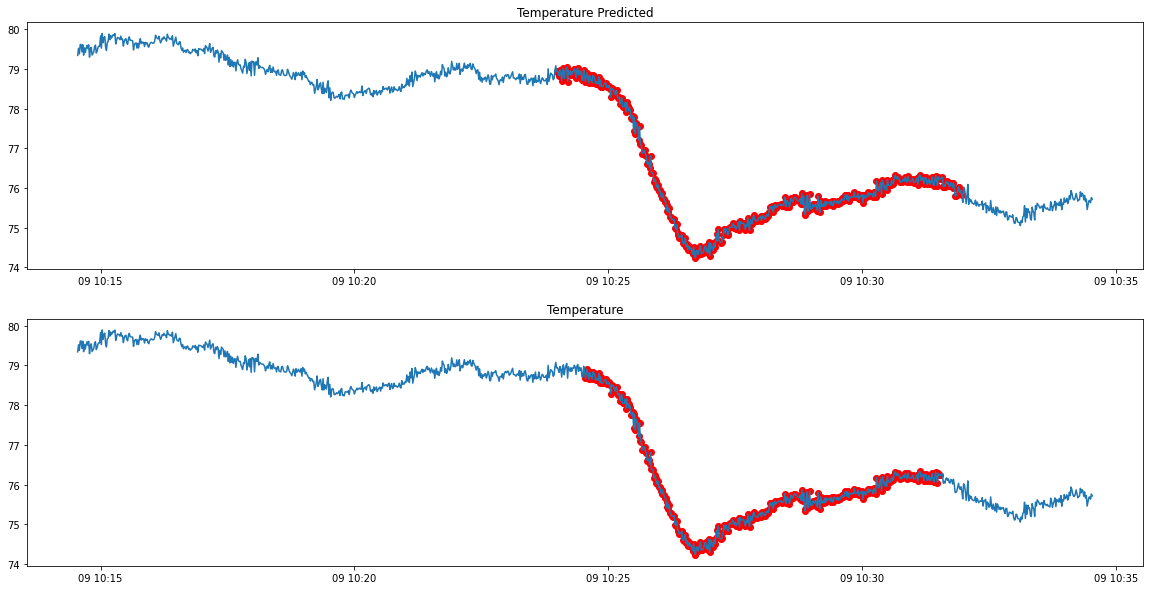

In [22]:
y_test = df.anomaly
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [23]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.9336437718277066
FAR = 0.07640750670241286
MAR = 0.0


### Применение метода ко всем датасетам

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 6s 70ms/step - loss: 0.9888
Epoch 2/10
53/53 [==============================] - 4s 75ms/step - loss: 0.9584
Epoch 3/10
53/53 [==============================] - 4s 73ms/step - loss: 134.4571
Epoch 4/10
53/53 [==============================] - 4s 74ms/step - loss: 0.9458
Epoch 5/10
53/53 [==============================] - 4s 71ms/step - loss: 0.9418
Epoch 6/10
53/53 [==============================] - 4s 69ms/step - loss: 0.9348
Epoch 7/10
53/53 [==============================] - 4s 70ms/step - loss: 0.9335
Epoch 8/10
53/53 [==============================] - 4s 68ms/step - loss: 1.0549
Epoch 9/10
53/53 [==============================] - 4s 77ms/step - loss: 0.9279
Epoch 10/10
53/53 [==============================] - 4s 69ms/step - loss: 0.9283
Epoch 1/10
53/53 [==============================] - 6s 68ms/step - loss: 150549584.0000
Epoch 2/10
53/53 [==============================] - 4s 71ms/step - loss: 0.9982
Epoch 3/10
53/53 [===========

IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 8s 81ms/step - loss: 3.9900
Epoch 2/10
52/52 [==============================] - 4s 81ms/step - loss: 1.1702
Epoch 3/10
52/52 [==============================] - 4s 75ms/step - loss: 0.9700
Epoch 4/10
52/52 [==============================] - 4s 78ms/step - loss: 0.9718
Epoch 5/10
52/52 [==============================] - 5s 102ms/step - loss: 1.0110
Epoch 6/10
52/52 [==============================] - 6s 110ms/step - loss: 1.0966
Epoch 7/10
52/52 [==============================] - 5s 105ms/step - loss: 5671.0288
Epoch 8/10
52/52 [==============================] - 5s 88ms/step - loss: 0.9813
Epoch 9/10
52/52 [==============================] - 4s 82ms/step - loss: 0.9872
Epoch 10/10
52/52 [==============================] - 4s 81ms/step - loss: 2.1801
Epoch 1/10
52/52 [==============================] - 8s 82ms/step - loss: 1565072424960.0000
Epoch 2/10
52/52 [==============================] - 4s 80ms/step - loss: 1.9856
Epoch 3/10
52/52 [===

IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
51/51 [==============================] - 8s 83ms/step - loss: 1.8517
Epoch 2/10
51/51 [==============================] - 4s 84ms/step - loss: 977.5826
Epoch 3/10
51/51 [==============================] - 4s 84ms/step - loss: 0.9499
Epoch 4/10
51/51 [==============================] - 4s 84ms/step - loss: 1.3057
Epoch 5/10
51/51 [==============================] - 4s 83ms/step - loss: 1.6399
Epoch 6/10
51/51 [==============================] - 4s 83ms/step - loss: 0.9410
Epoch 7/10
51/51 [==============================] - 4s 85ms/step - loss: 0.9270
Epoch 8/10
51/51 [==============================] - 4s 84ms/step - loss: 0.9058
Epoch 9/10
51/51 [==============================] - 5s 91ms/step - loss: 0.8853
Epoch 10/10
51/51 [==============================] - 5s 91ms/step - loss: 297.3486
F1 = 0.2888086642599278

FAR = 0.08797127468581688

MAR = 0.7872340425531915

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 85ms/step - loss: 458201.6250
Epoch 2/10
53/53 [==============================] - 6s 110ms/step - loss: 1.5786
Epoch 3/10
53/53 [==============================] - 5s 94ms/step - loss: 0.9750
Epoch 4/10
53/53 [==============================] - 4s 85ms/step - loss: 0.9707
Epoch 5/10
53/53 [==============================] - 4s 83ms/step - loss: 0.9666
Epoch 6/10
53/53 [==============================] - 4s 80ms/step - loss: 0.9483
Epoch 7/10
53/53 [==============================] - 4s 80ms/step - loss: 0.9555
Epoch 8/10
53/53 [==============================] - 4s 80ms/step - loss: 0.9447
Epoch 9/10
53/53 [==============================] - 4s 80ms/step - loss: 3.2736
Epoch 10/10
53/53 [==============================] - 4s 80ms/step - loss: 0.9174
F1 = 0.9693961952026469

FAR = 0.04993252361673414

MAR = 0.0

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 82ms/step - loss: 351.6557
Epoch 2/10
53/53 [==============================] - 4s 82ms/step - loss: 312602080.0000
Epoch 3/10
53/53 [==============================] - 4s 83ms/step - loss: 0.9583
Epoch 4/10
53/53 [==============================] - 5s 90ms/step - loss: 1.9516
Epoch 5/10
53/53 [==============================] - 5s 89ms/step - loss: 1.7850
Epoch 6/10
53/53 [==============================] - 4s 81ms/step - loss: 30.5051
Epoch 7/10
53/53 [==============================] - 4s 84ms/step - loss: 0.9620
Epoch 8/10
53/53 [==============================] - 5s 93ms/step - loss: 3.7429
Epoch 9/10
53/53 [==============================] - 5s 87ms/step - loss: 0.9584
Epoch 10/10
53/53 [==============================] - 5s 86ms/step - loss: 0.9918
F1 = 0.9298969072164949

FAR = 0.09201623815967523

MAR = 0.0

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 9s 84ms/step - loss: 406936.3750
Epoch 2/10
52/52 [==============================] - 4s 85ms/step - loss: 2.0806
Epoch 3/10
52/52 [==============================] - 5s 88ms/step - loss: 1.1210
Epoch 4/10
52/52 [==============================] - 4s 84ms/step - loss: 5.9452
Epoch 5/10
52/52 [==============================] - 4s 85ms/step - loss: 0.9629
Epoch 6/10
52/52 [==============================] - 4s 85ms/step - loss: 8.3081
Epoch 7/10
52/52 [==============================] - 5s 93ms/step - loss: 0.9858
Epoch 8/10
52/52 [==============================] - 5s 91ms/step - loss: 2.3855
Epoch 9/10
52/52 [==============================] - 5s 92ms/step - loss: 0.9758
Epoch 10/10
52/52 [==============================] - 5s 87ms/step - loss: 0.9650
F1 = 0.8753541076487252

FAR = 0.11907983761840325

MAR = 0.0

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
45/45 [==============================] - 7s 81ms/step - loss: 2550.1833
Epoch 2/10
45/45 [==============================] - 4s 86ms/step - loss: 0.9361
Epoch 3/10
45/45 [==============================] - 4s 81ms/step - loss: 5.4129
Epoch 4/10
45/45 [==============================] - 4s 82ms/step - loss: 0.9032
Epoch 5/10
45/45 [==============================] - 4s 82ms/step - loss: 0.8979
Epoch 6/10
45/45 [==============================] - 4s 83ms/step - loss: 0.8711
Epoch 7/10
45/45 [==============================] - 4s 82ms/step - loss: 0.8439
Epoch 8/10
45/45 [==============================] - 4s 83ms/step - loss: 0.8348
Epoch 9/10
45/45 [==============================] - 4s 84ms/step - loss: 0.8200
Epoch 10/10
45/45 [==============================] - 4s 82ms/step - loss: 1.1300
F1 = 0.0

FAR = 0.0

MAR = 1.0

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 92ms/step - loss: 0.9973
Epoch 2/10
53/53 [==============================] - 5s 103ms/step - loss: 0.9759
Epoch 3/10
53/53 [==============================] - 6s 108ms/step - loss: 0.9683
Epoch 4/10
53/53 [==============================] - 5s 103ms/step - loss: 0.9671
Epoch 5/10
53/53 [==============================] - 5s 94ms/step - loss: 0.9618
Epoch 6/10
53/53 [==============================] - 5s 90ms/step - loss: 0.9556
Epoch 7/10
53/53 [==============================] - 5s 88ms/step - loss: 0.9549
Epoch 8/10
53/53 [==============================] - 5s 88ms/step - loss: 0.9527
Epoch 9/10
53/53 [==============================] - 4s 81ms/step - loss: 0.9517
Epoch 10/10
53/53 [==============================] - 4s 81ms/step - loss: 0.9449
F1 = 0.7005649717514124

FAR = 0.07131011608623548

MAR = 0.3841059602649007

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
6/6 [==============================] - 4s 83ms/step - loss: 0.9453
Epoch 2/10
6/6 [==============================] - 1s 84ms/step - loss: 0.9369
Epoch 3/10
6/6 [==============================] - 1s 83ms/step - loss: 0.9239
Epoch 4/10
6/6 [==============================] - 0s 82ms/step - loss: 0.9125
Epoch 5/10
6/6 [==============================] - 1s 84ms/step - loss: 0.9023
Epoch 6/10
6/6 [==============================] - 0s 81ms/step - loss: 0.9187
Epoch 7/10
6/6 [==============================] - 0s 82ms/step - loss: 0.9151
Epoch 8/10
6/6 [==============================] - 1s 94ms/step - loss: 0.9060
Epoch 9/10
6/6 [==============================] - 1s 93ms/step - loss: 0.9012
Epoch 10/10
6/6 [==============================] - 1s 86ms/step - loss: 0.8975
F1 = 0.7901234567901234

FAR = 0.5151515151515151

MAR = 0.0

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
52/52 [==============================] - 8s 83ms/step - loss: 59.8660
Epoch 2/10
52/52 [==============================] - 4s 84ms/step - loss: 2.2682
Epoch 3/10
52/52 [==============================] - 4s 84ms/step - loss: 1.0001
Epoch 4/10
52/52 [==============================] - 4s 84ms/step - loss: 791.7392
Epoch 5/10
52/52 [==============================] - 4s 83ms/step - loss: 1.0496
Epoch 6/10
52/52 [==============================] - 4s 83ms/step - loss: 0.9992
Epoch 7/10
52/52 [==============================] - 4s 84ms/step - loss: 0.9825
Epoch 8/10
52/52 [==============================] - 4s 85ms/step - loss: 1.2437
Epoch 9/10
52/52 [==============================] - 4s 83ms/step - loss: 1.3583
Epoch 10/10
52/52 [==============================] - 4s 83ms/step - loss: 0.9886
F1 = 0.9636803874092009

FAR = 0.04059539918809202

MAR = 0.0

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
75/75 [==============================] - 9s 83ms/step - loss: 239936.7656
Epoch 2/10
75/75 [==============================] - 6s 82ms/step - loss: 37.7723
Epoch 3/10
75/75 [==============================] - 6s 81ms/step - loss: 1.2026
Epoch 4/10
75/75 [==============================] - 6s 81ms/step - loss: 3878.6233
Epoch 5/10
75/75 [==============================] - 6s 82ms/step - loss: 0.9655
Epoch 6/10
75/75 [==============================] - 6s 84ms/step - loss: 2.2009
Epoch 7/10
75/75 [==============================] - 6s 82ms/step - loss: 0.9418
Epoch 8/10
75/75 [==============================] - 6s 83ms/step - loss: 0.9290
Epoch 9/10
75/75 [==============================] - 6s 82ms/step - loss: 0.9155
Epoch 10/10
75/75 [==============================] - 6s 83ms/step - loss: 0.9089
F1 = 0.7539432176656151

FAR = 0.0

MAR = 0.3949367088607595

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 83ms/step - loss: 80266.6406
Epoch 2/10
53/53 [==============================] - 4s 83ms/step - loss: 0.9955
Epoch 3/10
53/53 [==============================] - 4s 82ms/step - loss: 0.9969
Epoch 4/10
53/53 [==============================] - 4s 83ms/step - loss: 52.2003
Epoch 5/10
53/53 [==============================] - 6s 114ms/step - loss: 0.9792
Epoch 6/10
53/53 [==============================] - 5s 93ms/step - loss: 33.4002
Epoch 7/10
53/53 [==============================] - 5s 90ms/step - loss: 0.9824
Epoch 8/10
53/53 [==============================] - 6s 107ms/step - loss: 0.9757
Epoch 9/10
53/53 [==============================] - 5s 92ms/step - loss: 1.0916
Epoch 10/10
53/53 [==============================] - 4s 84ms/step - loss: 0.9620
F1 = 0.9070796460176991

FAR = 0.11275167785234899

MAR = 0.0

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 7s 70ms/step - loss: 0.9604
Epoch 2/10
53/53 [==============================] - 4s 72ms/step - loss: 0.9455
Epoch 3/10
53/53 [==============================] - 4s 76ms/step - loss: 0.9436
Epoch 4/10
53/53 [==============================] - 4s 72ms/step - loss: 0.9386
Epoch 5/10
53/53 [==============================] - 4s 75ms/step - loss: 0.9330
Epoch 6/10
53/53 [==============================] - 5s 91ms/step - loss: 0.9354
Epoch 7/10
53/53 [==============================] - 4s 82ms/step - loss: 0.9220
Epoch 8/10
53/53 [==============================] - 4s 77ms/step - loss: 0.9290
Epoch 9/10
53/53 [==============================] - 6s 105ms/step - loss: 0.9121
Epoch 10/10
53/53 [==============================] - 5s 89ms/step - loss: 0.9115
F1 = 0.9105322763306908

FAR = 0.10604026845637583

MAR = 0.0

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 86ms/step - loss: 61.8468
Epoch 2/10
53/53 [==============================] - 6s 104ms/step - loss: 0.9986
Epoch 3/10
53/53 [==============================] - 5s 102ms/step - loss: 0.9910
Epoch 4/10
53/53 [==============================] - 5s 99ms/step - loss: 0.9737
Epoch 5/10
53/53 [==============================] - 5s 102ms/step - loss: 0.9927
Epoch 6/10
53/53 [==============================] - 5s 101ms/step - loss: 0.9598
Epoch 7/10
53/53 [==============================] - 6s 106ms/step - loss: 0.9448
Epoch 8/10
53/53 [==============================] - 6s 115ms/step - loss: 0.9398
Epoch 9/10
53/53 [==============================] - 6s 111ms/step - loss: 0.9314
Epoch 10/10
53/53 [==============================] - 5s 97ms/step - loss: 0.9264
F1 = 0.895483870967742

FAR = 0.10901749663526245

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 8s 87ms/step - loss: 128.4747
Epoch 2/10
53/53 [==============================] - 5s 97ms/step - loss: 0.9728
Epoch 3/10
53/53 [==============================] - 5s 95ms/step - loss: 75.9892
Epoch 4/10
53/53 [==============================] - 5s 98ms/step - loss: 1.2473
Epoch 5/10
53/53 [==============================] - 5s 85ms/step - loss: 0.9833
Epoch 6/10
53/53 [==============================] - 5s 86ms/step - loss: 1.0152
Epoch 7/10
53/53 [==============================] - 6s 118ms/step - loss: 2.6685
Epoch 8/10
53/53 [==============================] - 5s 102ms/step - loss: 1.6284
Epoch 9/10
53/53 [==============================] - 6s 110ms/step - loss: 0.9685
Epoch 10/10
53/53 [==============================] - 5s 100ms/step - loss: 3.0049
F1 = 0.834850455136541

FAR = 0.06048387096774194

MAR = 0.20347394540942929

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

Epoch 1/10
53/53 [==============================] - 11s 113ms/step - loss: 26016172.0000
Epoch 2/10
53/53 [==============================] - 5s 101ms/step - loss: 2.2756
Epoch 3/10
53/53 [==============================] - 4s 85ms/step - loss: 28.8723
Epoch 4/10
53/53 [==============================] - 5s 86ms/step - loss: 1.2017
Epoch 5/10
53/53 [==============================] - 5s 87ms/step - loss: 0.9908
Epoch 6/10
53/53 [==============================] - 5s 94ms/step - loss: 0.9755
Epoch 7/10
53/53 [==============================] - 5s 88ms/step - loss: 0.9436
Epoch 8/10
53/53 [==============================] - 5s 85ms/step - loss: 0.9570
Epoch 9/10
53/53 [==============================] - 5s 87ms/step - loss: 0.9700
Epoch 10/10
53/53 [==============================] - 4s 85ms/step - loss: 1.0915
F1 = 0.9031531531531531

FAR = 0.11574697173620457

MAR = 0.0

CPU times: total: 1h 10min 48s
Wall time: 26min 17s


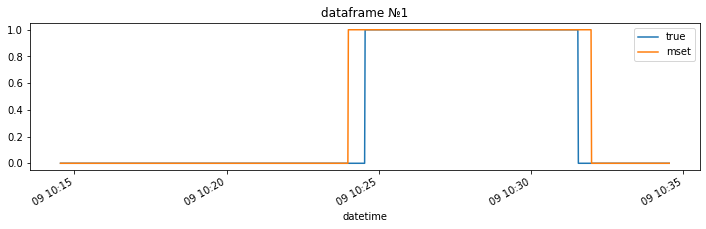

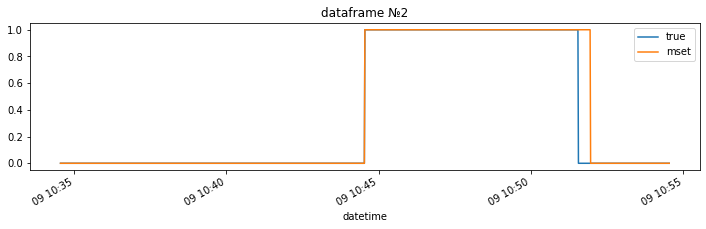

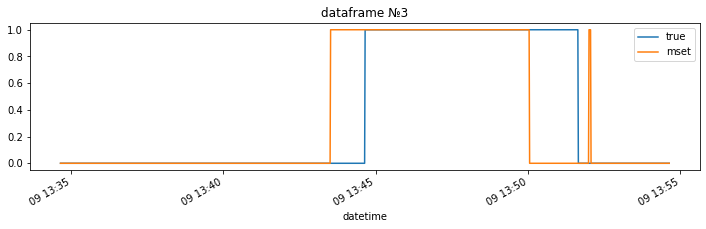

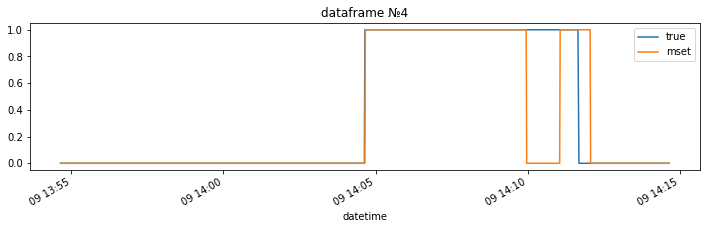

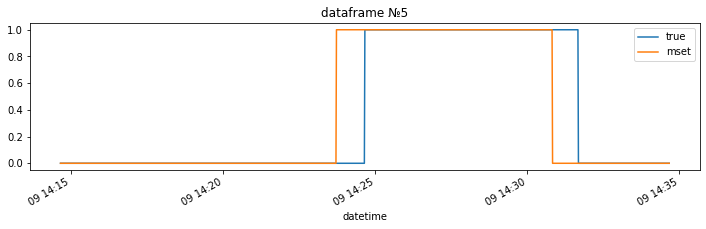

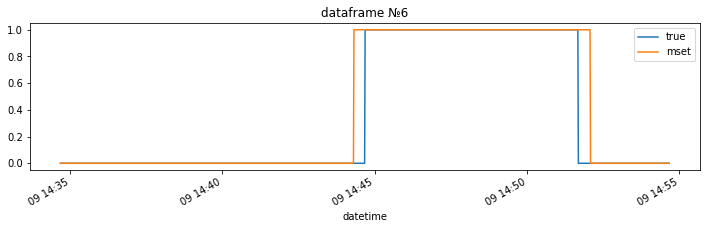

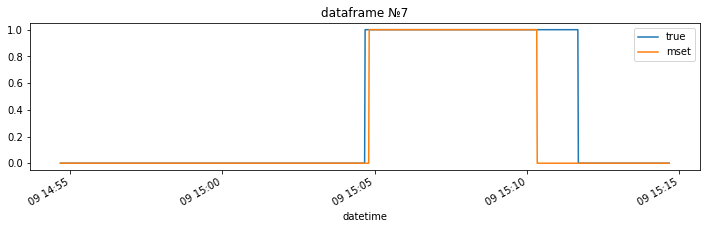

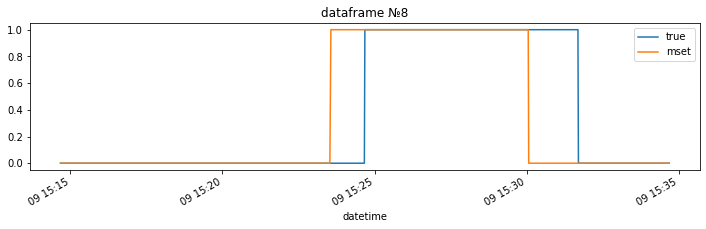

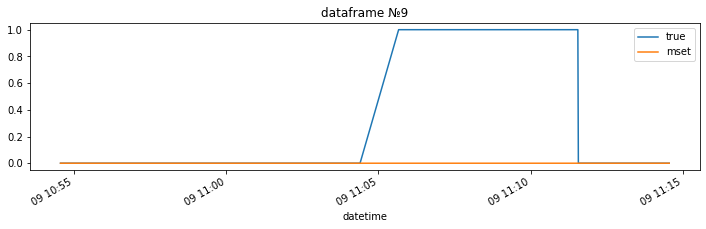

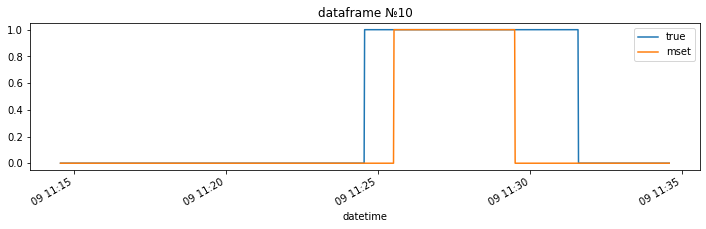

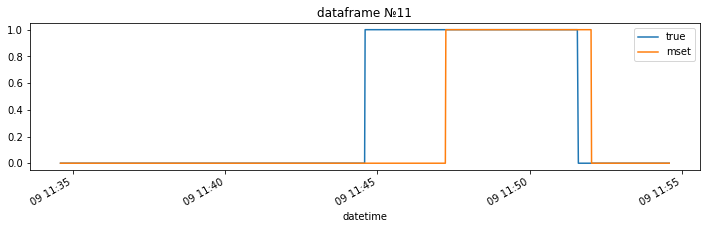

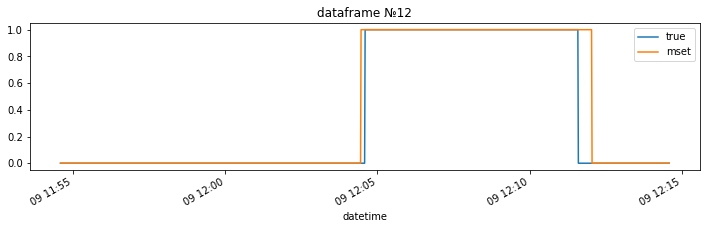

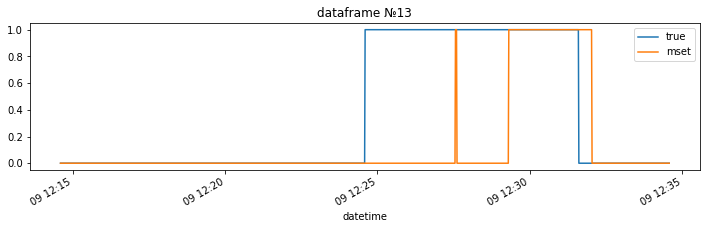

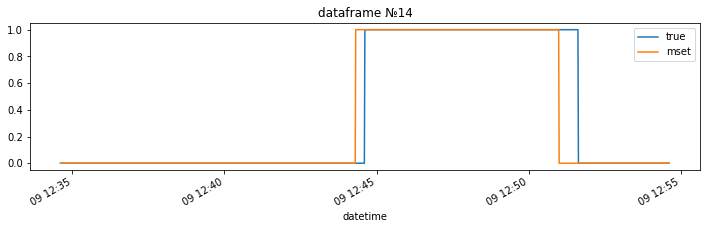

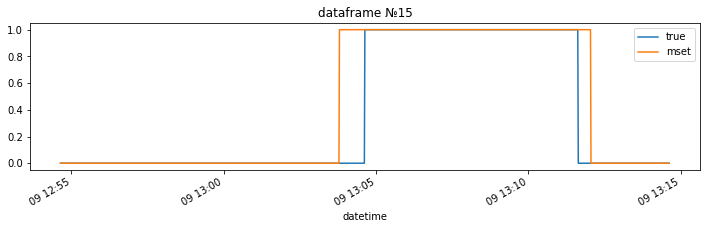

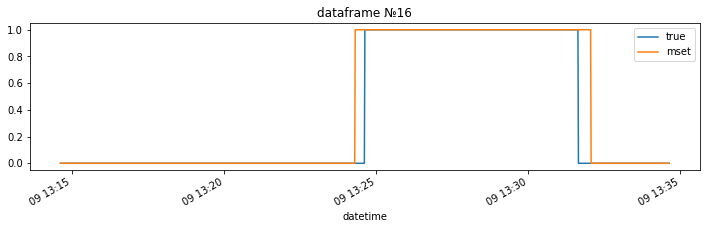

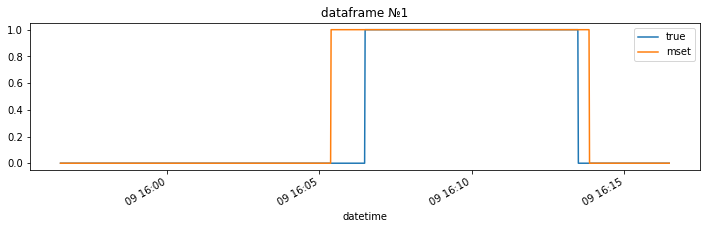

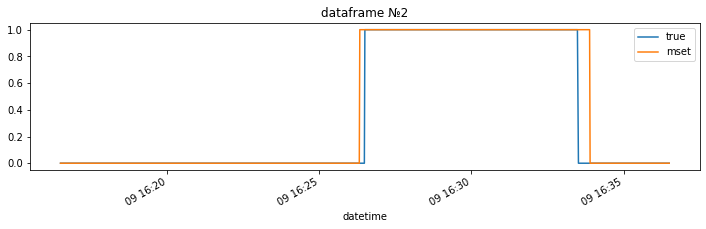

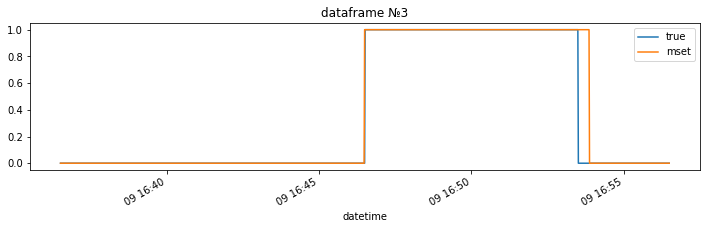

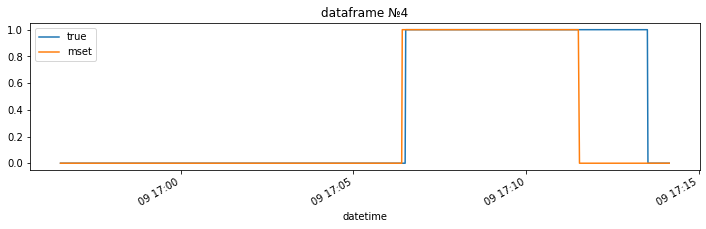

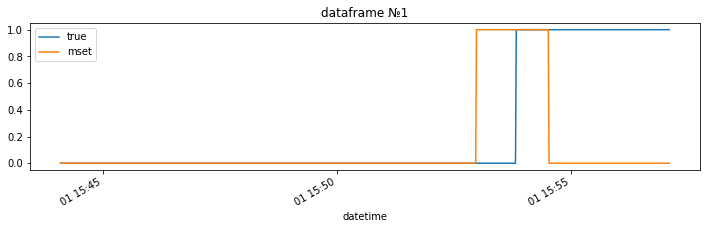

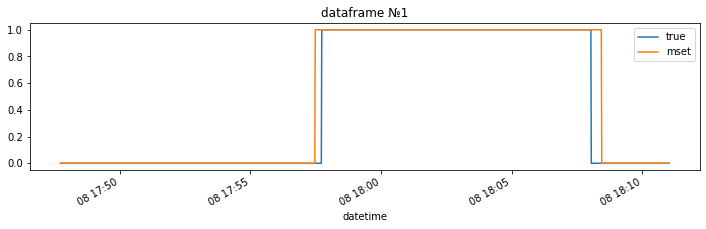

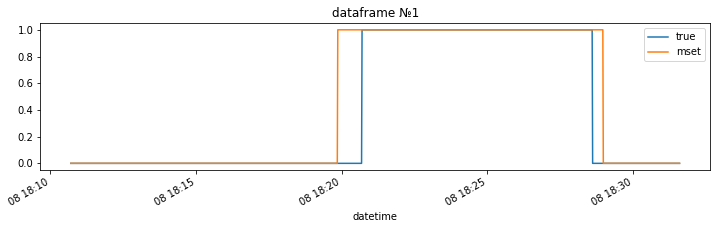

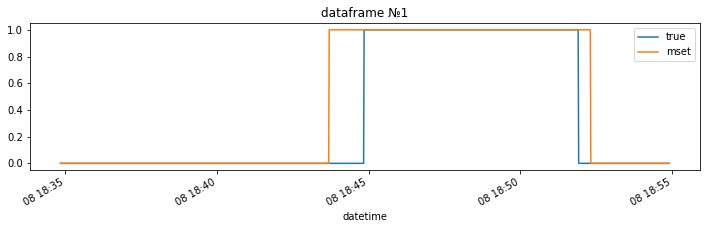

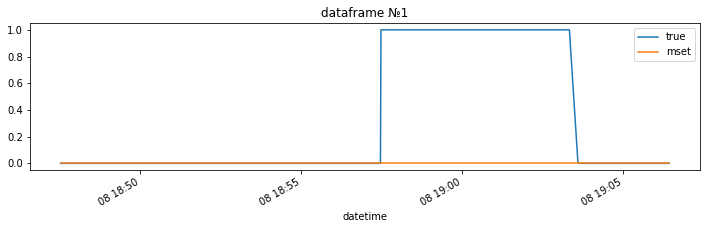

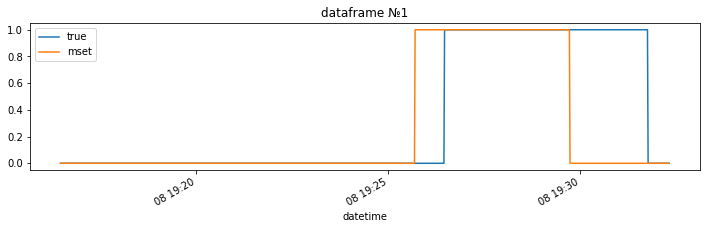

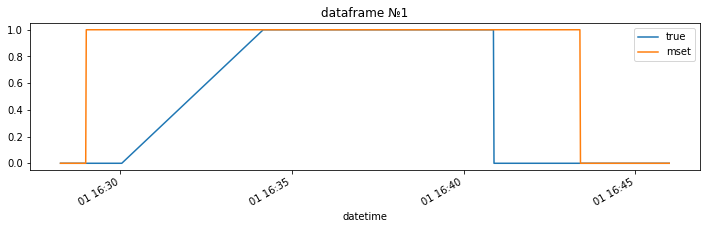

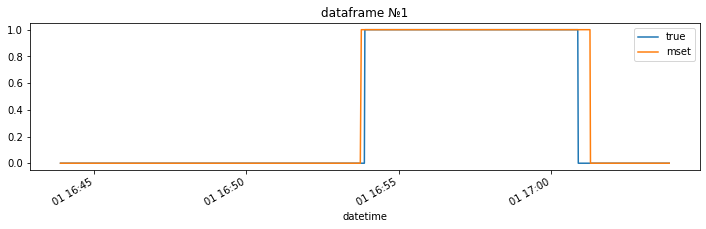

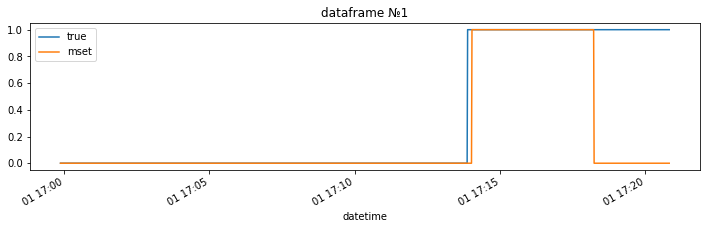

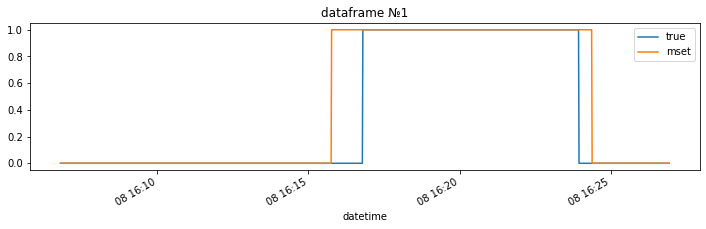

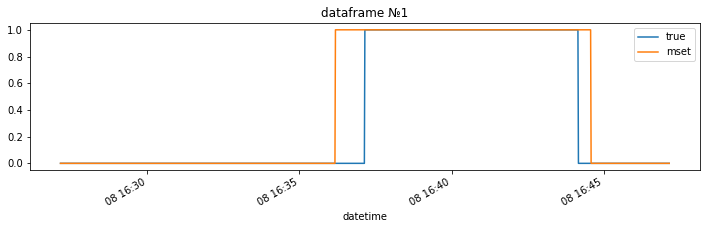

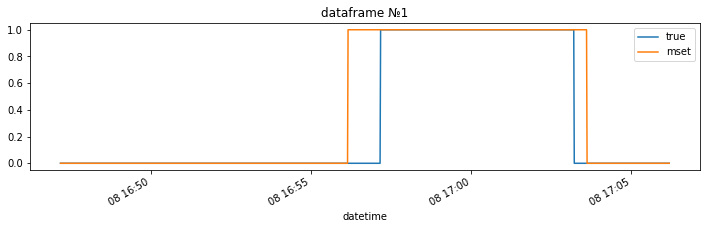

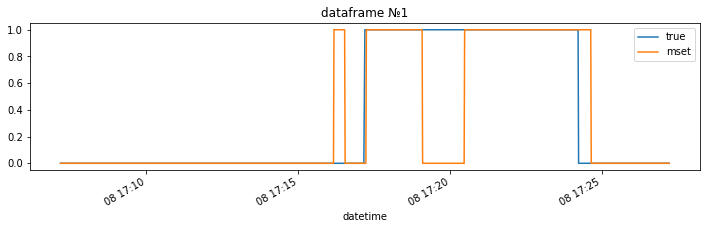

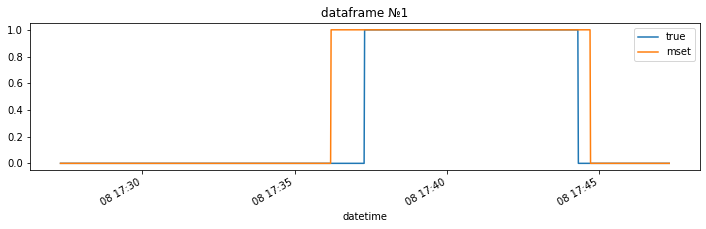

In [25]:
%%time
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = LSTM_VAE_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [26]:
from utils.metrics import f1_score, far, mar

pred_outlier = pd.concat([pd.concat(p.all_predictions[i]) 
                          for i in range(len(p.all_predictions))])

list_of_all_df = []
for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            list_of_all_df.append(pd.concat([df.anomaly for df in [df, ]]))
    else:
        list_of_all_df.append(pd.concat([df.anomaly for df in list_of_df]))

true_outlier = pd.concat(list_of_all_df)

f1 = f1_score(true_outlier, pred_outlier)
far_score = far(true_outlier, pred_outlier)
mar_score = mar(true_outlier, pred_outlier)

metrics["all"] = (f1, far_score, mar_score)

In [27]:
from utils.data import show_score_table

show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.84 | 0.92 | 0.29 | 0.97 | 0.93 | 0.88 | 0.0 | 0.7 | 0.79 | 0.96 | 0.75 | 0.91 | 0.91 | 0.9 | 0.83 | 0.9 | 0.85
FAR |0.05 | 0.05 | 0.09 | 0.05 | 0.09 | 0.12 | 0.0 | 0.07 | 0.52 | 0.04 | 0.0 | 0.11 | 0.11 | 0.11 | 0.06 | 0.12 | 0.07
MAR |0.21 | 0.07 | 0.79 | 0.0 | 0.0 | 0.0 | 1.0 | 0.38 | 0.0 | 0.0 | 0.39 | 0.0 | 0.0 | 0.0 | 0.2 | 0.0 | 0.17